In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

In [2]:
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

In [3]:
#Cargo los datasets
df_1 = pd.read_csv('tp-2020-2c-train-cols1.csv')
df_2 = pd.read_csv('tp-2020-2c-train-cols2.csv')

Recibimos de la compañía FiuMark dos datasets, los cuales fueron importados a los dataframes ```df_1``` y ```df_2```

Notamos que ambos contienen 801 filas, y que tienen en común el campo ```id_usuario```

In [4]:
df_1.shape

(801, 3)

In [5]:
df_1.head()

,Unnamed: 0,id_usuario,volveria
0,116,117,0
1,657,658,0
2,793,794,0
3,454,455,0
4,172,173,1


In [6]:
df_2.shape

(801, 12)

In [7]:
df_2.head()

,Unnamed: 0,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,116,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes
1,657,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes
2,793,normal,Señor Antonio Federico,794,hombre,NaN,0,0,"RE""39822",3,NaN,fiumark_chacarita
3,454,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,"C17""4:39",1,NaN,fiumark_palermo
4,172,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo


Intentamos mediante el campo ```id_usuario``` obtener un dataset consolidado a partir de los dos originales. Notamos que la cantidad de filas es la misma.

In [8]:
df_full = df_2.merge(df_1, on='id_usuario')
df_full.shape

(801, 14)

In [9]:
df_full.head()

,Unnamed: 0_x,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede,Unnamed: 0_y,volveria
0,116,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes,116,0
1,657,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes,657,0
2,793,normal,Señor Antonio Federico,794,hombre,NaN,0,0,"RE""39822",3,NaN,fiumark_chacarita,793,0
3,454,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,"C17""4:39",1,NaN,fiumark_palermo,454,0
4,172,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo,172,1


Notando que las columnas Unnamed: 0_x y Unnamed: 0_y contienen el id de usuario menos uno, consideramos descartarlas.
Generamos ```df_full_1``` sin dichas columnas.

In [10]:
df_full_1 = df_full.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
df_full_1.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede,volveria
0,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes,0
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes,0
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,"RE""39822",3,NaN,fiumark_chacarita,0
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,"C17""4:39",1,NaN,fiumark_palermo,0
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo,1


Con el dataset unificado, inspeccionamos los datos en busqueda de valores nulos y/o sin sentido.

**Preprocesamiento**

Hallamos que las columnas ```edad```, ```fila``` y ```nombre_sede``` contienen valores explicitamente nulos.

In [11]:
for col in df_full_1.columns:
    if df_full_1[col].hasnans:
        print(col + " tiene valores nulos")

edad tiene valores nulos
fila tiene valores nulos
nombre_sede tiene valores nulos


Determinamos qué proporción de valores en dichos campos son nulos:

In [12]:
df_full_1['edad'].isnull().value_counts(normalize=True)*100

False    80.024969
True     19.975031
Name: edad, dtype: float64

In [13]:
df_full_1['fila'].isnull().value_counts(normalize=True)*100

True     77.902622
False    22.097378
Name: fila, dtype: float64

In [14]:
df_full_1['nombre_sede'].isnull().value_counts(normalize=True)*100

False    99.750312
True      0.249688
Name: nombre_sede, dtype: float64

En este caso vemos además la cantidad exacta:

In [15]:
df_full_1['nombre_sede'].isnull().value_counts()

False    799
True       2
Name: nombre_sede, dtype: int64

Vemos que los dos registros sin nombre de sede tienen el mismo valor de ```id_ticket```

In [16]:
df_full_1.loc[df_full_1['nombre_sede'].isnull() == True]

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede,volveria
494,normal,Señora Matilde Carolina,830,mujer,65.0,0,0,335794,8,adelante,NaN,1
649,normal,Señorita Rosa Cornelia,62,mujer,41.0,0,0,335794,8,adelante,NaN,1


Generamos una visualización más directa de que valores son nulos en el dataset.

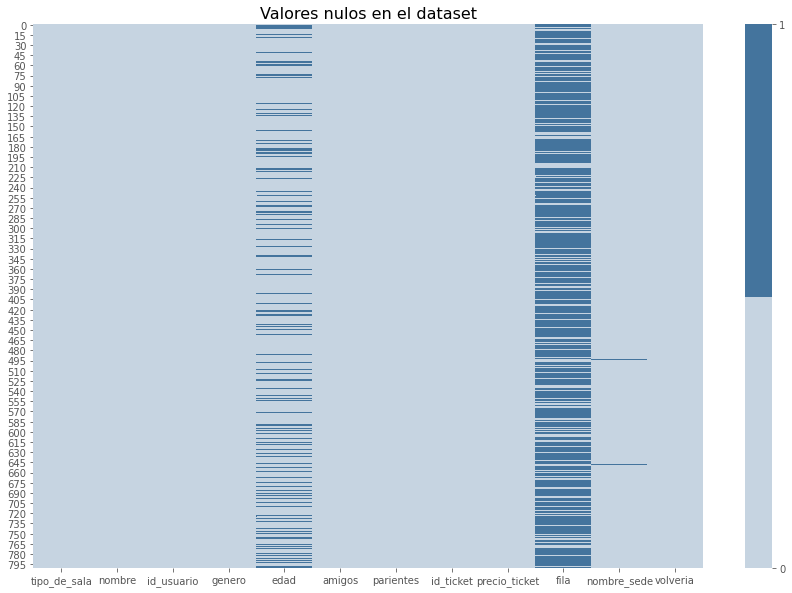

In [17]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Valores nulos en el dataset", fontsize=16)
colors = ['#C6D4E1','#44749D']
sns.heatmap(df_full_1.isnull(), cmap=sns.color_palette(colors), cbar_kws=dict(ticks=[1, 0]))
plt.show()

Confirmamos que las únicas columnas con valores explícitamente nulos son ```edad```, ```fila``` y ```nombre_sede```.
Dada la gran cantidad de valores faltantes (77.9%) en la columna ```fila```, decidimos no considerarla para el análisis.

Consideramos reemplazar los valores faltantes en la columna ```edad``` por la moda.

In [18]:
_df_con_edad = df_full_1.loc[df_full_1['edad'].isna() == False]
_edad_mode = _df_con_edad['edad'].mode()[0]
_edad_mode

27.0

In [19]:
df_full_1['edad'].fillna(_edad_mode, inplace=True)
df_full_1

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede,volveria
0,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes,0
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes,0
2,normal,Señor Antonio Federico,794,hombre,27.0,0,0,"RE""39822",3,NaN,fiumark_chacarita,0
3,4d,Señor Osvaldo Aureliano,455,hombre,27.0,0,0,"C17""4:39",1,NaN,fiumark_palermo,0
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo,1
...,...,...,...,...,...,...,...,...,...,...,...,...
796,normal,Señor Bernardo Melesio,448,hombre,37.0,0,0,3359;6,3,NaN,fiumark_palermo,1
797,3d,Señorita Lidia Catalina,636,mujer,31.0,0,0,45988:,2,NaN,fiumark_palermo,1
798,4d,Señor Arturo Antenor,848,hombre,38.0,0,0,56;435,1,NaN,fiumark_chacarita,0
799,3d,Señorita Natividad Sofia,304,mujer,27.0,0,0,4487;5,2,adelante,fiumark_quilmes,1


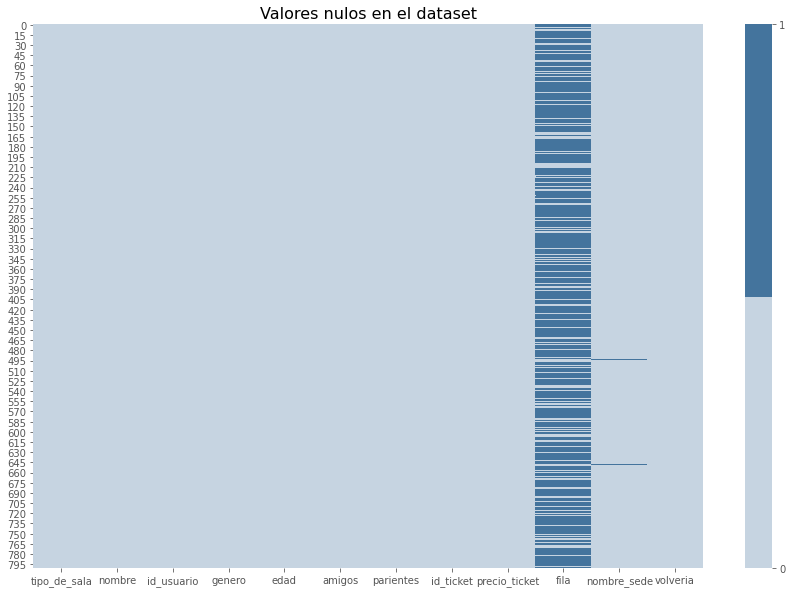

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Valores nulos en el dataset", fontsize=16)
colors = ['#C6D4E1','#44749D']
sns.heatmap(df_full_1.isnull(), cmap=sns.color_palette(colors), cbar_kws=dict(ticks=[1, 0]))
plt.show()

# Análisis

### 1. Qué proporción de los entrevistados volvería?

In [21]:
df_full_1['volveria'].replace({1:"Volveria", 0:"No volveria"}).value_counts()

No volveria    494
Volveria       307
Name: volveria, dtype: int64

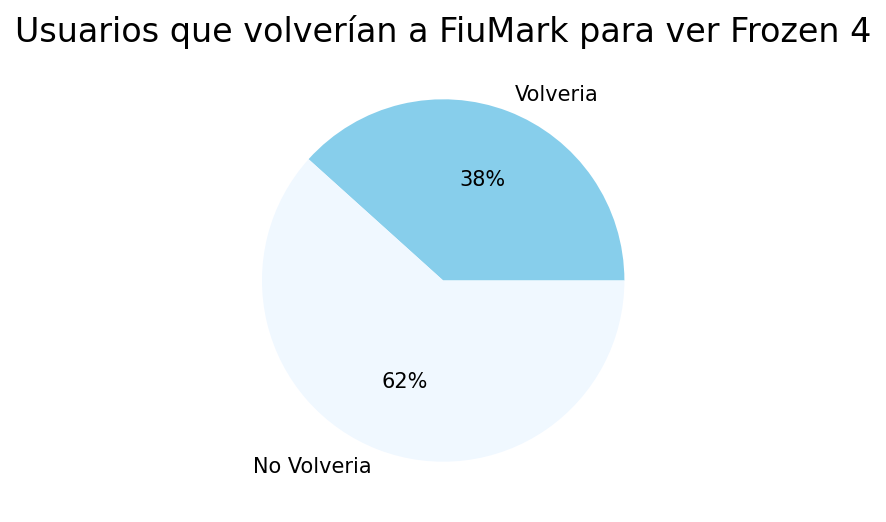

In [22]:
fig, ax = plt.subplots(dpi=(150))

volveria = df_full_1['volveria'].replace({1:"Volveria", 0:"No volveria"}).value_counts().sort_index(ascending=False)

_labels = ['Volveria', 'No Volveria']
_colors = ['skyblue', 'aliceblue']

ax.set_title("Usuarios que volverían a FiuMark para ver Frozen 4", fontsize=16)
ax.pie(volveria, colors=_colors, autopct="%1.0f%%", labels=_labels)
plt.show()

Vimos que la mayoria en los encuestados no volvería a FiuMark para ver Frozen 4.

### **2. A que sedes corresponden los entrevistados?**

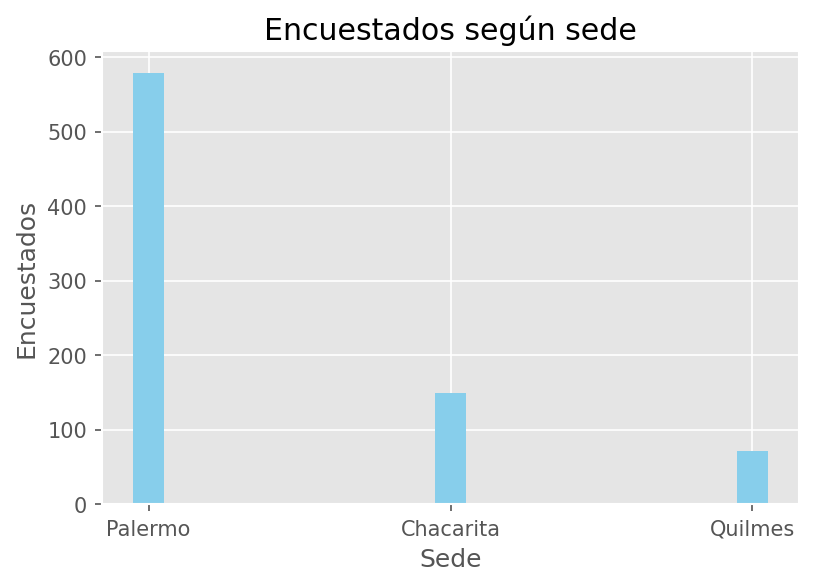

In [23]:
plt.figure(dpi=(150))
d = {"fiumark_palermo":"Palermo", "fiumark_chacarita":"Chacarita","fiumark_quilmes":"Quilmes"}
por_sede = df_full_1['nombre_sede'].replace(d).value_counts()
plt.bar(por_sede.index, por_sede.values, width=0.1, color="skyblue")
plt.ylabel("Encuestados")
plt.xlabel("Sede")
plt.title("Encuestados según sede")
plt.show()

### **2.1. Influye la sede en el target?**

In [24]:
df_full_1.loc[df_full_1['nombre_sede'].eq('fiumark_palermo')]['volveria'].value_counts()

0    384
1    195
Name: volveria, dtype: int64

In [25]:
df_full_1.loc[df_full_1['nombre_sede'].eq('fiumark_chacarita')]['volveria'].value_counts()

1    83
0    66
Name: volveria, dtype: int64

In [26]:
df_full_1.loc[df_full_1['nombre_sede'].eq('fiumark_quilmes')]['volveria'].value_counts()

0    44
1    27
Name: volveria, dtype: int64

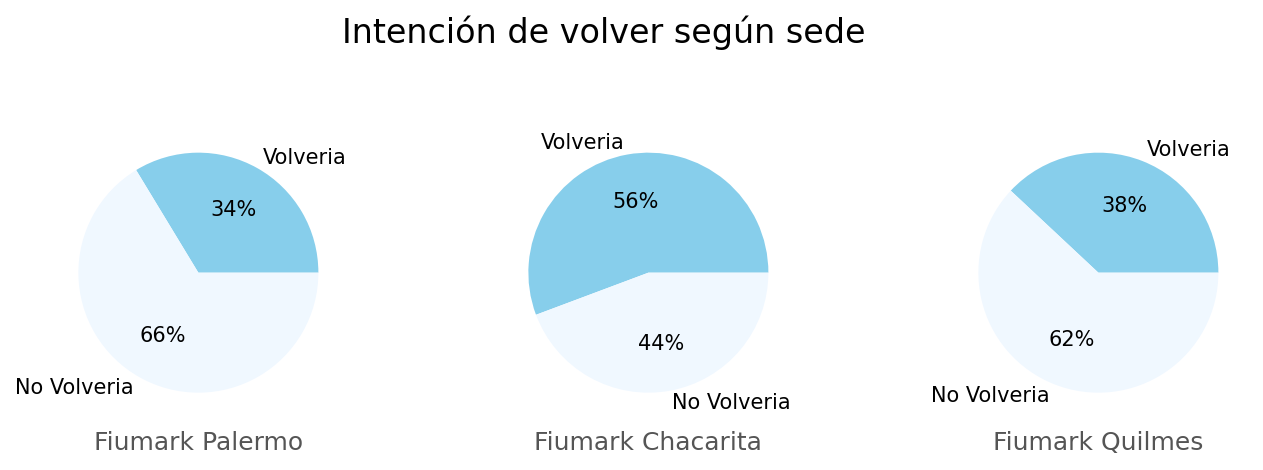

In [27]:
fig = plt.figure(dpi=(150))
fig.suptitle("Intención de volver según sede", fontsize=16, x=0.7)
fiumark_palermo = df_full_1.loc[df_full_1['nombre_sede'].eq('fiumark_palermo')]['volveria'].value_counts().sort_index(ascending=False)
fiumark_chacarita = df_full_1.loc[df_full_1['nombre_sede'].eq('fiumark_chacarita')]['volveria'].value_counts().sort_index(ascending=False)
fiumark_quilmes = df_full_1.loc[df_full_1['nombre_sede'].eq('fiumark_quilmes')]['volveria'].value_counts().sort_index(ascending=False)

_labels = ['Volveria', 'No Volveria']
_colors = ['skyblue', 'aliceblue']

ax1 = fig.add_axes([0, 0.3, .5, .5], aspect=1)
ax1.set_xlabel("Fiumark Palermo")
ax1.pie(fiumark_palermo, colors=_colors, autopct="%1.0f%%", labels=_labels)
ax2 = fig.add_axes([.5, 0.3, .5, .5], aspect=1)
ax2.set_xlabel("Fiumark Chacarita")
ax2.pie(fiumark_chacarita, colors=_colors, autopct="%1.0f%%", labels=_labels)
ax3 = fig.add_axes([1, 0.3, .5, 0.5], aspect=1)
ax3.set_xlabel("Fiumark Quilmes")
ax3.pie(fiumark_quilmes, colors=_colors, autopct="%1.0f%%", labels=_labels)
plt.show()

Vemos que la unica sede en la que la mayoria de los encuestados volvería, es en la sede de Chacarita.

### **3. Que salas utilizaron los encuestados?**

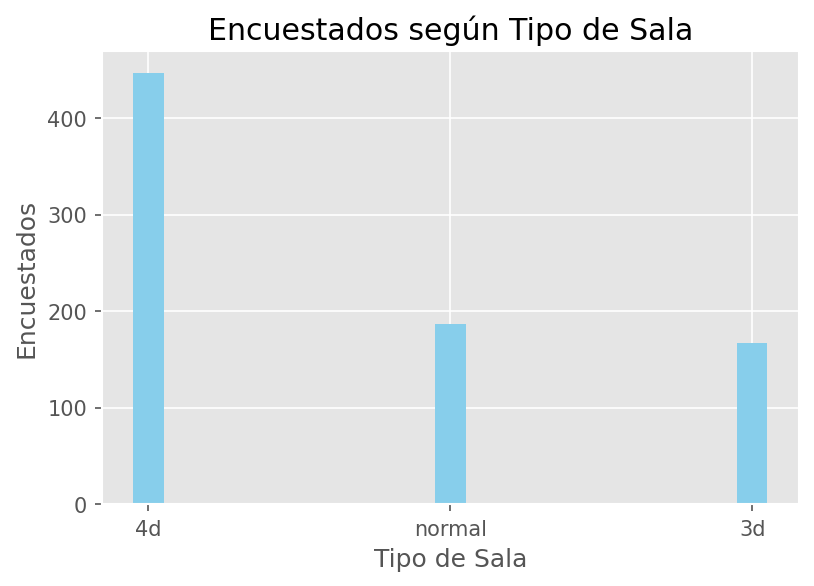

In [28]:
plt.figure(dpi=(150))
d = {"fiumark_palermo":"Palermo", "fiumark_chacarita":"Chacarita","fiumark_quilmes":"Quilmes"}
por_sede = df_full_1['tipo_de_sala'].value_counts()
plt.bar(por_sede.index, por_sede.values, width=0.1, color="skyblue")
plt.ylabel("Encuestados")
plt.xlabel("Tipo de Sala")
plt.title("Encuestados según Tipo de Sala")
plt.show()

### **3.1 Influye el tipo de sala en el target?**

In [29]:
df_full_1.loc[df_full_1['tipo_de_sala'].eq('4d')]['volveria'].value_counts()

0    342
1    105
Name: volveria, dtype: int64

In [30]:
df_full_1.loc[df_full_1['tipo_de_sala'].eq('3d')]['volveria'].value_counts()

0    85
1    82
Name: volveria, dtype: int64

In [31]:
df_full_1.loc[df_full_1['tipo_de_sala'].eq('normal')]['volveria'].value_counts()

1    120
0     67
Name: volveria, dtype: int64

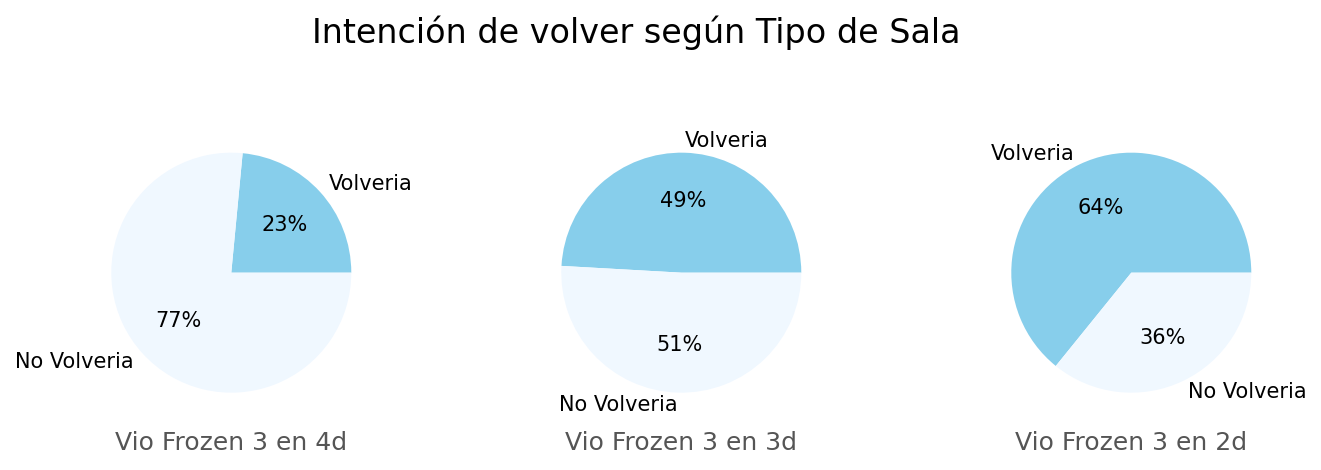

In [32]:
fig = plt.figure(dpi=(150))
fig.suptitle("Intención de volver según Tipo de Sala", fontsize=16, x=0.7)
_4d = df_full_1.loc[df_full_1['tipo_de_sala'].eq('4d')]['volveria'].value_counts().sort_index(ascending=False)
_3d = df_full_1.loc[df_full_1['tipo_de_sala'].eq('3d')]['volveria'].value_counts().sort_index(ascending=False)
_2d = df_full_1.loc[df_full_1['tipo_de_sala'].eq('normal')]['volveria'].value_counts().sort_index(ascending=False)

_labels = ['Volveria', 'No Volveria']
_colors = ['skyblue', 'aliceblue']

ax1 = fig.add_axes([0, 0.3, .5, .5], aspect=1)
ax1.set_xlabel("Vio Frozen 3 en 4d")
ax1.pie(_4d, colors=_colors, autopct="%1.0f%%", labels=_labels)
ax2 = fig.add_axes([.5, 0.3, .5, .5], aspect=1)
ax2.set_xlabel("Vio Frozen 3 en 3d")
ax2.pie(_3d, colors=_colors, autopct="%1.0f%%", labels=_labels)
ax3 = fig.add_axes([1, 0.3, .5, 0.5], aspect=1)
ax3.set_xlabel("Vio Frozen 3 en 2d")
ax3.pie(_2d, colors=_colors, autopct="%1.0f%%", labels=_labels)
plt.show()

Vemos que el único caso en el que la mayoría de los encuestados volvería, es el caso de quienes vieron Frozen 3 en 2d.

### 4. Qué tipos de entradas se pagaron

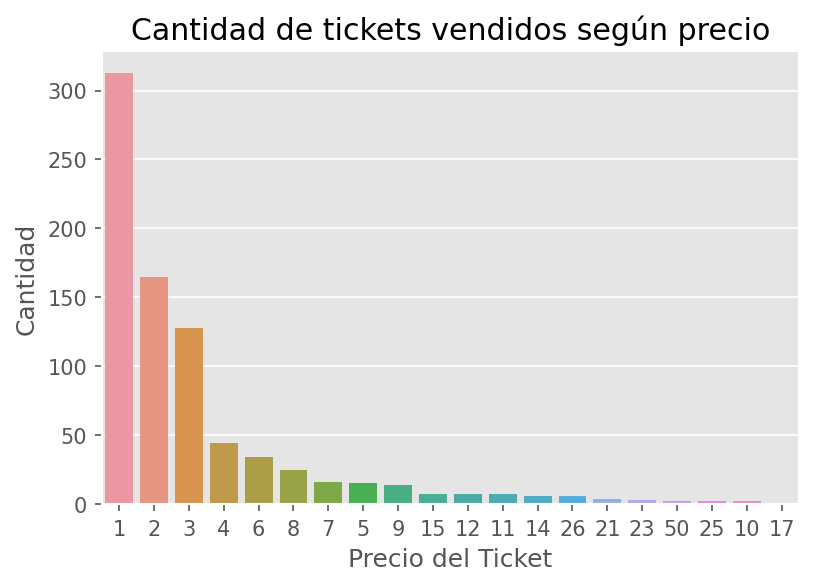

In [33]:


plt.figure(dpi=150)
sns.countplot(
    x="precio_ticket", data=df_full_1, order=df_full_1["precio_ticket"].value_counts().index
)
plt.ylabel("Cantidad")
plt.xlabel("Precio del Ticket")
plt.title("Cantidad de tickets vendidos según precio")
plt.xticks(rotation=0)
plt.show()



### 5. Que cantidad fue solo? Que cantidad fue acompañado?

In [34]:
solos = df_full_1.loc[(df_full_1['amigos'] == 0) & (df_full_1['parientes'] == 0)]
con_amigos = df_full_1.loc[(df_full_1['amigos'] > 0) & (df_full_1['parientes'] == 0)]
con_parientes = df_full_1.loc[(df_full_1['amigos'] == 0) & (df_full_1['parientes'] > 0)]
con_ambos = df_full_1.loc[(df_full_1['amigos'] > 0) & (df_full_1['parientes'] > 0)]

In [35]:
solos.shape

(493, 12)

In [36]:
solos.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede,volveria
0,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes,0
2,normal,Señor Antonio Federico,794,hombre,27.0,0,0,"RE""39822",3,NaN,fiumark_chacarita,0
3,4d,Señor Osvaldo Aureliano,455,hombre,27.0,0,0,"C17""4:39",1,NaN,fiumark_palermo,0
5,normal,Señor Raimundo Longino,352,hombre,27.0,0,0,335732,4,adelante,fiumark_palermo,0
7,4d,Señor Carlos Gregorio,91,hombre,32.0,0,0,565498,1,NaN,fiumark_palermo,0


In [37]:
con_amigos.shape

(114, 12)

In [38]:
con_amigos.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede,volveria
8,normal,Señor Carlos Roberto Francisco,225,hombre,41.0,1,0,3;;65,9,adelante,fiumark_palermo,1
27,4d,Señor Lorenzo Segundo,126,hombre,15.0,1,0,4873,2,NaN,fiumark_chacarita,1
29,normal,Señor Manuel Antonio Segundo,742,hombre,39.0,1,0,3;:99,8,adelante,fiumark_palermo,0
35,3d,Señora Carmen Greunisia,855,mujer,47.0,1,0,466474,3,NaN,fiumark_palermo,0
39,normal,Señor Enrique Washington,749,hombre,22.0,1,0,335995,6,adelante,fiumark_palermo,0


In [39]:
con_parientes.shape

(64, 12)

In [40]:
con_parientes.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede,volveria
9,normal,Señora Lidia Barbarita,880,mujer,59.00,0,1,33989,9,adelante,fiumark_chacarita,1
19,3d,Señora Ana Rosa Esilda,881,mujer,28.00,0,1,452655,3,NaN,fiumark_palermo,1
32,normal,Señor Balbino Humberto,156,hombre,54.00,0,1,"RE""397;9",6,NaN,fiumark_chacarita,0
38,3d,Señor Alberto De,828,hombre,4.00,0,2,"U0E01RCTKU""429;",4,NaN,fiumark_chacarita,1
50,3d,Señor Juan Osvaldo,79,hombre,3.83,0,2,46:95:,3,NaN,fiumark_palermo,1


In [41]:
con_ambos.shape

(130, 12)

In [42]:
con_ambos.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede,volveria
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes,0
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo,1
6,4d,Señor Celestino Wenceslao,177,hombre,27.0,3,1,6355,3,NaN,fiumark_palermo,0
15,4d,Señorita Anselma Josefina,230,mujer,27.0,3,1,6355,3,NaN,fiumark_palermo,0
21,4d,Señorita Sonia,11,mujer,7.0,1,1,"RR"";76;",2,medio,fiumark_palermo,1


### 5.1. Influye con quien fue en el target?

In [43]:
solos['volveria'].value_counts()

0    342
1    151
Name: volveria, dtype: int64

In [44]:
con_amigos['volveria'].value_counts()

1    58
0    56
Name: volveria, dtype: int64

In [45]:
con_parientes['volveria'].value_counts()

1    43
0    21
Name: volveria, dtype: int64

In [46]:
con_ambos['volveria'].value_counts()

0    75
1    55
Name: volveria, dtype: int64

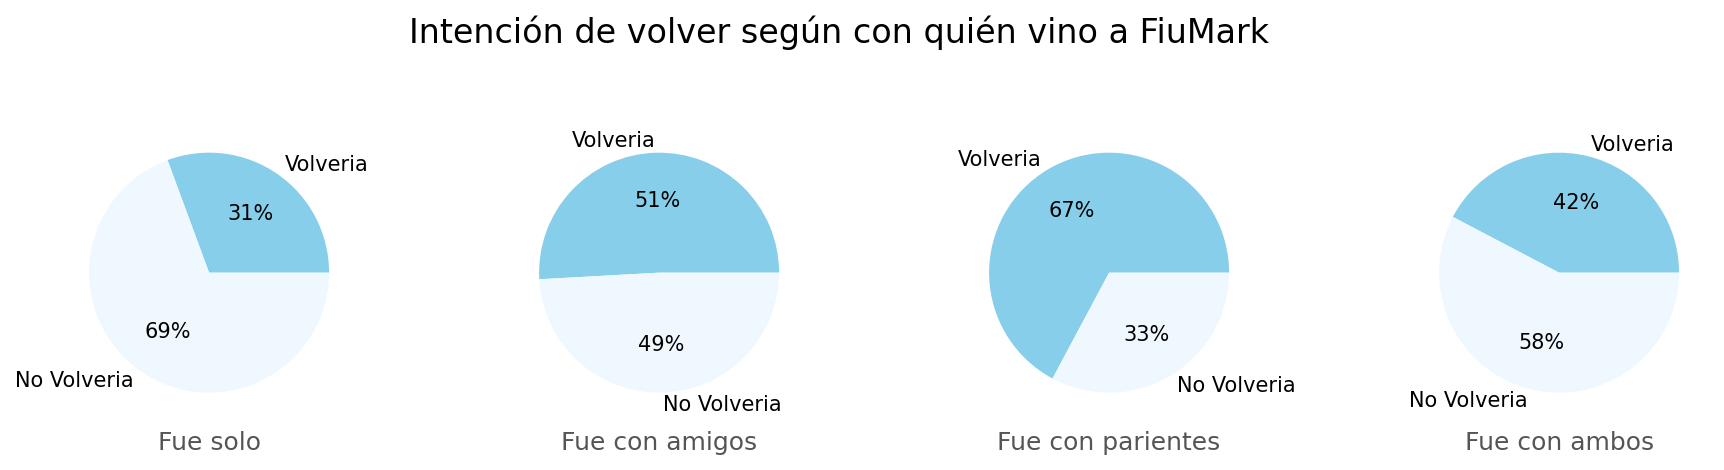

In [47]:
fig = plt.figure(dpi=(150))
fig.suptitle("Intención de volver según con quién vino a FiuMark", fontsize=16, x=0.95)

_v1 = solos['volveria'].value_counts().sort_index(ascending=False);
_v2 = con_amigos['volveria'].value_counts().sort_index(ascending=False);
_v3 = con_parientes['volveria'].value_counts().sort_index(ascending=False);
_v4 = con_ambos['volveria'].value_counts().sort_index(ascending=False);

_labels = ['Volveria', 'No Volveria']
_colors = ['skyblue', 'aliceblue']

ax1 = fig.add_axes([0, 0.3, .5, .5], aspect=1)
ax1.set_xlabel("Fue solo")
ax1.pie(_v1, colors=_colors, autopct="%1.0f%%", labels=_labels)

ax2 = fig.add_axes([.5, 0.3, .5, .5], aspect=1)
ax2.set_xlabel("Fue con amigos")
ax2.pie(_v2, colors=_colors, autopct="%1.0f%%", labels=_labels)

ax3 = fig.add_axes([1, 0.3, .5, 0.5], aspect=1)
ax3.set_xlabel("Fue con parientes")
ax3.pie(_v3, colors=_colors, autopct="%1.0f%%", labels=_labels)

ax4 = fig.add_axes([1.5, 0.3, .5, 0.5], aspect=1)
ax4.set_xlabel("Fue con ambos")
ax4.pie(_v4, colors=_colors, autopct="%1.0f%%", labels=_labels)

plt.show()

Vemos que la mayoria de quienes vinieron con parientes o con amigos, volverían a FiuMark para ver Frozen 4.

### 6. Que cantidad de encuestados hubo segun genero?

In [48]:
df_full_1['genero'].value_counts()

hombre    513
mujer     288
Name: genero, dtype: int64

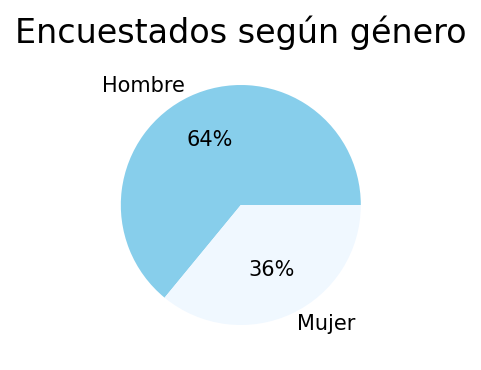

In [88]:
fig = plt.figure(dpi=(150))

_v1 = df_full_1['genero'].value_counts();

ax1 = fig.add_axes([1, 0, .5, .5], aspect=1)
ax1.pie(_v1, colors=['skyblue', 'aliceblue'], autopct="%1.0f%%", labels=['Hombre', 'Mujer'])
ax1.set_title("Encuestados según género", fontsize=16)

plt.show()

### 6.1 Influye el género en el target?

In [50]:
mujeres = df_full_1.loc[df_full_1['genero'].eq('mujer')]
hombres = df_full_1.loc[df_full_1['genero'].eq('hombre')]

In [51]:
hombres['volveria'].value_counts()

0    419
1     94
Name: volveria, dtype: int64

In [52]:
mujeres['volveria'].value_counts()

1    213
0     75
Name: volveria, dtype: int64

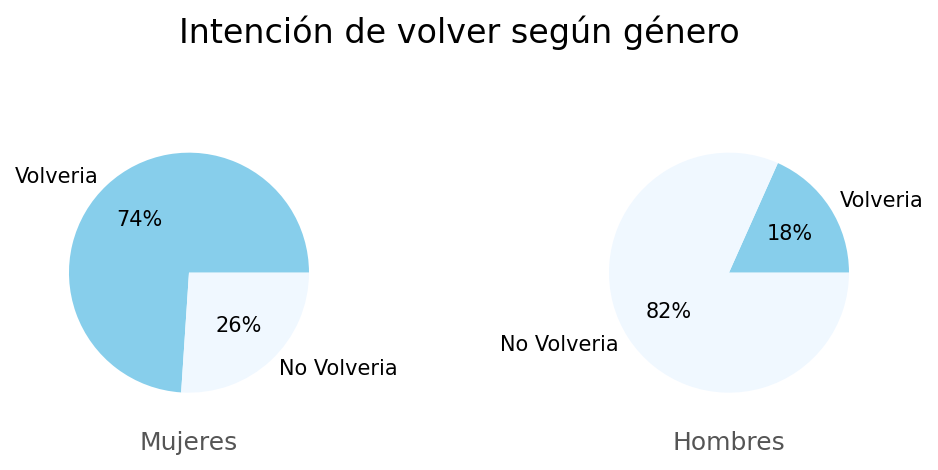

In [53]:
fig = plt.figure(dpi=(150))
fig.suptitle("Intención de volver según género", fontsize=16, x=0.55)

_v1 = mujeres['volveria'].value_counts().sort_index(ascending=False);
_v2 = hombres['volveria'].value_counts().sort_index(ascending=False);

_labels = ['Volveria', 'No Volveria']
_colors = ['skyblue', 'aliceblue']

ax1 = fig.add_axes([0, 0.3, .5, .5], aspect=1)
ax1.set_xlabel("Mujeres")
ax1.pie(_v1, colors=_colors, autopct="%1.0f%%", labels=_labels)

ax2 = fig.add_axes([.6, 0.3, .5, .5], aspect=1)
ax2.set_xlabel("Hombres")
ax2.pie(_v2, colors=_colors, autopct="%1.0f%%", labels=_labels)
plt.show()

### 7. En qué rango etario estan los encuestados?

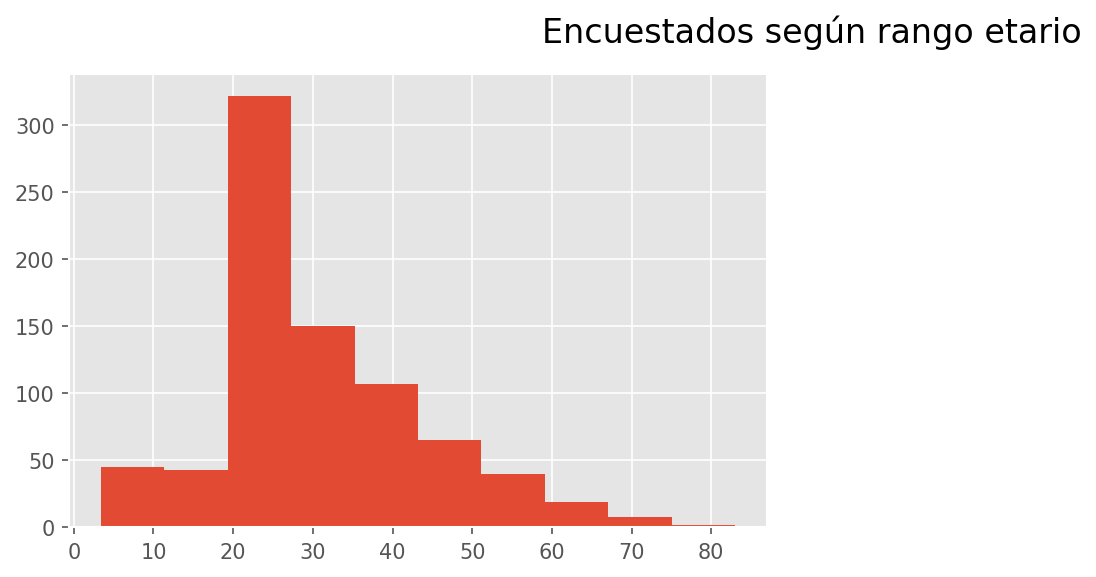

In [54]:
fig, ax1 = plt.subplots(dpi=(150))
fig.suptitle("Encuestados según rango etario", fontsize=16, x=0.95)


ax1.hist(df_full_1['edad'], bins=10)
plt.show()

In [55]:
hasta_20 = df_full_1.loc[df_full_1['edad'] <= 20]
_20_a_40 = df_full_1.loc[(df_full_1['edad'] > 20)&(df_full_1['edad'] <= 40)]
_40_a_60 = df_full_1.loc[(df_full_1['edad'] > 40)&(df_full_1['edad'] <= 60)]
mas_60 = df_full_1.loc[df_full_1['edad'] > 60]

In [56]:
hasta_20['volveria'].value_counts()

1    53
0    47
Name: volveria, dtype: int64

In [57]:
_20_a_40['volveria'].value_counts()

0    342
1    191
Name: volveria, dtype: int64

In [58]:
_40_a_60['volveria'].value_counts()

0    86
1    54
Name: volveria, dtype: int64

In [59]:
mas_60['volveria'].value_counts()

0    19
1     9
Name: volveria, dtype: int64

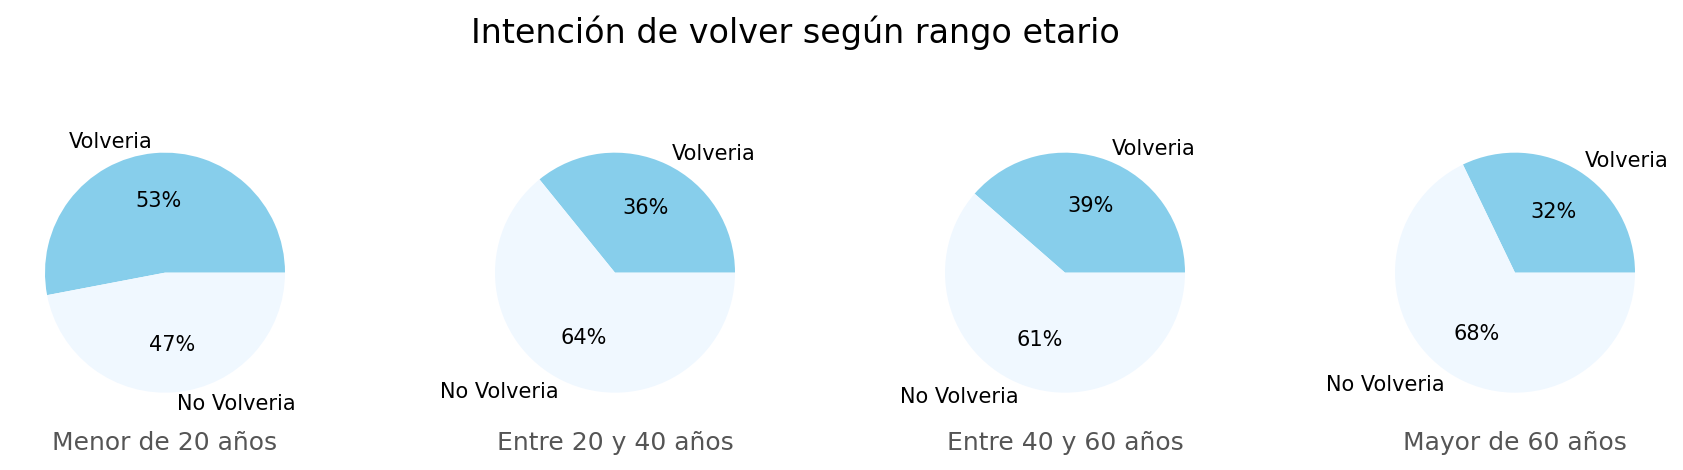

In [60]:
fig = plt.figure(dpi=(150))
fig.suptitle("Intención de volver según rango etario", fontsize=16, x=0.95)

_v1 = hasta_20['volveria'].value_counts().sort_index(ascending=False);
_v2 = _20_a_40['volveria'].value_counts().sort_index(ascending=False);
_v3 = _40_a_60['volveria'].value_counts().sort_index(ascending=False);
_v4 = mas_60['volveria'].value_counts().sort_index(ascending=False);

_labels = ['Volveria', 'No Volveria']
_colors = ['skyblue', 'aliceblue']

ax1 = fig.add_axes([0, 0.3, .5, .5], aspect=1)
ax1.set_xlabel("Menor de 20 años")
ax1.pie(_v1, colors=_colors, autopct="%1.0f%%", labels=_labels)

ax2 = fig.add_axes([.5, 0.3, .5, .5], aspect=1)
ax2.set_xlabel("Entre 20 y 40 años")
ax2.pie(_v2, colors=_colors, autopct="%1.0f%%", labels=_labels)

ax3 = fig.add_axes([1, 0.3, .5, 0.5], aspect=1)
ax3.set_xlabel("Entre 40 y 60 años")
ax3.pie(_v3, colors=_colors, autopct="%1.0f%%", labels=_labels)

ax4 = fig.add_axes([1.5, 0.3, .5, 0.5], aspect=1)
ax4.set_xlabel("Mayor de 60 años")
ax4.pie(_v4, colors=_colors, autopct="%1.0f%%", labels=_labels)

plt.show()

# Codigo Baseline Propuesto

In [61]:
def preprocess(df):
    #print('preprocess')
    return df

def predict(row):
    if row['genero'] == 'mujer':
        return 1
    else:
        return 0
    
def baseline(df):
    pp_df = preprocess(df)
    df_cp = pp_df.copy()
    df_cp['pred'] = df_cp.apply(predict, axis=1)
    return df_cp['pred'].tolist()


In [62]:
baseline(df_full_1)

[0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,


Comprobación de accuracy

In [63]:
result = baseline(df_full_1)
as_series = pd.Series(result)
(df_full_1['volveria'] == as_series).replace({True:"Acierto", False:"Error"}).value_counts(normalize=True)

Acierto    0.789014
Error      0.210986
dtype: float64